# Importing Requerments:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:

from datetime import datetime
import pandas as pd
import numpy as np
import sys
import statistics as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error, mean_absolute_percentage_error

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Quality check: Statistical feature extraction:

In [ ]:
regression_dataset['all_authors'] = None
for index in range(len(regression_dataset)):
  if (str(regression_dataset.co_Author[index]) != 'nan'):
    regression_dataset.co_Author[index] = regression_dataset.co_Author[index].replace('،', ',')
    regression_dataset.all_authors[index] = regression_dataset.Author[index]+', '+ regression_dataset.co_Author[index]
  else:
    regression_dataset.all_authors[index] = regression_dataset.Author[index]

In [ ]:
def find_match(author):
  count=0
  for y in regression_dataset.all_authors:
    if (author.strip() in y):
      count+=1
  return(count)

In [ ]:
regression_dataset['max_publication_authors'] = None
for i,x in enumerate(regression_dataset.all_authors):
  auths = x.split(',')
  pub_freq = []
  for a in auths:
    pub_freq.append(find_match(a))
  regression_dataset.max_publication_authors[i] = max(pub_freq)

In [ ]:
def paper_parser(paper):
  paragraphs = paper.split('\n')
  title_end = 0
  abstract_ind = 0
  keywords_ind = 0
  en_abs_ind = 0
  en_key_ind = 0
  intro_ind = 0
  ref_ind = 0
  end_ref =0
  end_abstract =0
  eng_end_abstract =0
  keywords_end=0
  for i, line in enumerate(paragraphs):
    if ('ملخص' in line and abstract_ind ==0):
      abstract_ind = i 
      continue
    elif ('خلاصة' in line and abstract_ind ==0):
      abstract_ind = i 
      continue
    elif ('مستخلص' in line and abstract_ind ==0):
      abstract_ind = i 
      continue
    if ('مفتاحي' in line and keywords_ind ==0): 
      keywords_ind = i
      continue
    elif ('الكلمات الدالة' in line and keywords_ind ==0): 
      keywords_ind = i
      continue 
    elif ('كلمات دالة' in line and keywords_ind ==0): 
      keywords_ind = i
      continue
    if ('abstract' in line and en_abs_ind ==0):
      en_abs_ind = i
      continue
    elif ('absract' in line and en_abs_ind ==0):
      en_abs_ind = i
      continue
    if ('keyword' in line and en_key_ind ==0):
      en_key_ind = i
      continue
    elif ('key w' in line and en_key_ind ==0):
      en_key_ind = i
      continue
    if ('مقدمة' in line and intro_ind ==0):
      intro_ind = i
      continue
    if ('مراجع' in line):
      ref_ind = i
      continue
    elif ('مصادر' in line and ref_ind ==0):
      ref_ind = i
      continue    
    elif ('reference' in line):
      ref_ind = i
      continue
    def get_paragraph(start_idx, end_idx):
      parag = ''
      for i in range(start_idx, end_idx):
        parag = parag +' '+ paragraphs[i]
      return parag
    
  if (abstract_ind == 0): print('No Arabic Abstract Found!')
  if (keywords_ind == 0): 
    print('No Arabic keywords Found!')
    keywords_end = 0
    if(en_abs_ind != 0 and en_abs_ind < ref_ind):
      end_abstract = en_abs_ind
    else:
      end_abstract = intro_ind
  else:
    keywords_end = keywords_ind+1
    end_abstract = keywords_ind
  if (en_abs_ind == 0): 
    print('No English Abstract Found!')
    title_end = abstract_ind
  else:
    title_end = min(abstract_ind, en_abs_ind)
  if (en_key_ind == 0): 
    print('No English keywords Found!')
    en_key_end = 0
    if(en_abs_ind < ref_ind and en_abs_ind < abstract_ind):
      eng_end_abstract = abstract_ind
    elif (en_abs_ind < ref_ind and en_abs_ind < intro_ind):
      eng_end_abstract = intro_ind
    else:
      eng_end_abstract = len(paragraphs)
  else:
    eng_end_abstract = en_key_ind
    en_key_end = en_key_ind +1
  if (en_abs_ind > ref_ind):
    end_ref = en_abs_ind -1
  else:
    end_ref =len(paragraphs)


  title = get_paragraph(0, title_end)    
  abstract = get_paragraph(abstract_ind+1, end_abstract)
  key_words = get_paragraph(keywords_ind, keywords_end)    
  en_abstract = get_paragraph(en_abs_ind +1, eng_end_abstract)   
  en_keyword = get_paragraph(en_key_ind, en_key_end) 
  introduction = get_paragraph(intro_ind +1, ref_ind)
  references = get_paragraph(ref_ind+1, end_ref)

  indexes = [abstract_ind, keywords_ind, en_abs_ind, en_key_ind, intro_ind, ref_ind]
  return(indexes, title, abstract, key_words, en_abstract, en_keyword, introduction, references)

In [ ]:
regression_dataset['title'] = None
regression_dataset['abstract'] = None
regression_dataset['key_words'] = None
regression_dataset['en_abstract'] = None
regression_dataset['en_keyword'] = None
regression_dataset['introduction'] = None
regression_dataset['references'] = None

In [ ]:
for i, pap in enumerate(regression_dataset.full_text):
  print('index: ', i)
  x, regression_dataset['title'][i], regression_dataset['abstract'][i],\
  regression_dataset['key_words'][i], regression_dataset['en_abstract'][i],\
  regression_dataset['en_keyword'][i], regression_dataset['introduction'][i],\
  regression_dataset['references'][i] = paper_parser(pap)

In [ ]:
def get_latest_reference_year(references):
  pattern = re.compile(r'\d\d\d\d')
  references_years = pattern.findall(references)
  years = [int(year) for year in references_years if (int(year) > 1950 and int(year)< 2025)]
  if (len(years) > 0 ):
    return (len(years), max(years), min(years), round(st.mean(years),2), round(st.median(years),2))
  else: 
    print('empty')
    return (0, 0, 0, 0, 0)
  

In [ ]:
regression_dataset['num_references'] = None
regression_dataset['latest_reference'] = None
regression_dataset['oldest_reference'] = None
regression_dataset['meadian_reference'] = None

for i, ref in enumerate(regression_dataset.references):
  counts, maxim, minim, means, medians = get_latest_reference_year(ref)
  regression_dataset.num_references[i] = counts
  regression_dataset.latest_reference[i] = maxim
  regression_dataset.oldest_reference[i] = minim 
  regression_dataset.meadian_reference[i] = medians

In [ ]:
# number of figurs & tabels
def get_figurs(paper_txt):
  pattern1 = re.compile(r'شكل*\s*.\d')
  pattern2 = re.compile(r'شكل*\sرقم*.\d')
  pattern3 = re.compile(r'جدول*\s*.\d')  # *.\d
  pattern4 = re.compile(r'جدول*\sرقم*.\d')  
  pattern5 = re.compile(r'مخطط*\s*.\d')  
  pattern6 = re.compile(r'مخطط*\sرقم*.\d')  


  figurs = pattern1.findall(paper_txt)
  figurs2 = pattern2.findall(paper_txt)
  tabels = pattern3.findall(paper_txt)
  tabels2 = pattern4.findall(paper_txt)
  charts = pattern5.findall(paper_txt)
  charts2 = pattern6.findall(paper_txt)

  join = lambda x: ' '.join(x)
  figurs = join(figurs) + join(figurs2) 
  tabels = join(tabels) + join(tabels2)
  charts = join(charts) + join(charts2)

  pattern4 = re.compile(r'\d')
  fig_num = pattern4.findall(figurs)
  tab_num = pattern4.findall(tabels)
  chr_num = pattern4.findall(charts)

  if len(fig_num)>0: max_fig = int(max(fig_num))
  else: max_fig = 0
  if len(tab_num)>0: max_tab = int(max(tab_num))
  else: max_tab = 0
  if len(chr_num)>0: max_chrt = int(max(chr_num))
  else: max_chrt = 0

  return (max_fig, max_tab, max_chrt)

In [ ]:
regression_dataset['num_figurs'] = None
regression_dataset['num_tables'] = None
regression_dataset['num_charts'] = None

for i, introd in enumerate(regression_dataset.introduction):
  x, y, z = get_figurs(introd)
  regression_dataset['num_figurs'][i] = x
  regression_dataset['num_tables'][i] = y
  regression_dataset['num_charts'][i] = z

In [ ]:
# fill null values with 0
regression_dataset['co_Author'] = regression_dataset['co_Author'].fillna(0)
df1 = regression_dataset[regression_dataset['co_Author'].isnull()]

In [ ]:
def num_authors(names):
  if(names == 0):
    return 1
  else:
    return(len(names.split(',')) +1)

In [ ]:
regression_dataset['num_authors'] = regression_dataset['co_Author'].map(num_authors)

In [ ]:
def avg_recent_references(latest,oldest,median):
  a = latest - median
  b = latest - oldest
  return (a/b)

In [ ]:
regression_dataset['avg_recent_references']= None
for i, x in enumerate(regression_dataset.latest_reference):
  oldest = regression_dataset.oldest_reference[i]
  mid = regression_dataset.meadian_reference[i]
  regression_dataset['avg_recent_references'][i]= avg_recent_references(x, oldest, mid)

In [ ]:
regression_dataset['avg_recent_references']

In [ ]:
leng = lambda x: len(x.split())
regression_dataset['paper_len'] = regression_dataset['full_text'].map(leng)

In [ ]:
# english/arabic words average
def ar_counter(text):
    ar_text = re.findall(r'[\u0600-\u06ff]+', str(text))
    return len(ar_text)

def en_counter(text):
  en_text = re.findall(r"[a-z]['\w]*", str(text))
  return len(en_text)

regression_dataset['ar_word_count'] = regression_dataset['full_text'].map(ar_counter)
regression_dataset['en_word_count'] = regression_dataset['full_text'].map(en_counter)

In [ ]:
regression_dataset['ar_word_avg'] = None
for i,x in enumerate(regression_dataset['ar_word_count']):
  regression_dataset['ar_word_avg'][i] = float(x)/float(regression_dataset['paper_len'][i])
regression_dataset['en_word_avg'] = None
for i,x in enumerate(regression_dataset['en_word_count']):
  regression_dataset['en_word_avg'][i] = float(x)/float(regression_dataset['paper_len'][i])


In [ ]:
def num_sentences(paper):
  sentences = paper.split('.')
  counter = 0
  for sent in sentences:
    if (len(sent.split()) >3):
      counter += 1
  return counter

regression_dataset['num_sentences'] = regression_dataset['full_text'].map(num_sentences)

In [ ]:
def avg_words_per_sentence(paper):
  sentences = paper.split('.')
  counter = 0
  len_list = 0
  for sent in sentences:
    if (len(sent.split()) >3):
      counter += 1
      len_list += (len(sent.split()))
  return (len_list / counter)

In [ ]:
regression_dataset['avg_words_per_sentence'] = regression_dataset['full_text'].map(avg_words_per_sentence)

In [ ]:
regression_dataset.info()

In [ ]:

def ref_mention_count(paper, oldest_ref, latest_ref):
  count = 0
  for ref in range(oldest_ref, latest_ref+1):
    count += paper.count(str(ref))
  return count

regression_dataset['ref_mention_count'] = None
for i,x in enumerate(regression_dataset.full_text):
  oldest = int(regression_dataset['oldest_reference'][i])
  latest = int(regression_dataset['latest_reference'][i])
  regression_dataset['ref_mention_count'][i] = ref_mention_count(x, oldest, latest)


In [ ]:
regression_dataset['num_publication'] = None
for i,author in enumerate(regression_dataset.all_authors):
  names = author.split(',')
  count = 0
  for name in names:
    for line in regression_dataset.all_authors:
      if name in line:
        count += 1
  regression_dataset['num_publication'][i] = count
print(count)

In [ ]:
regression_dataset.to_csv(r'/content/drive/MyDrive/decision_data4.csv')

# Dataset pre-processing:

In [ ]:
# statistical features
stat_dataset = pd.read_csv(r'/content/drive/MyDrive/decision_data4.csv')
stat_dataset.info()

In [ ]:
stat_regression = stat_dataset.drop(columns=['Unnamed: 0', 'Unnamed: 0.1','Unnamed: 0.2', 'Article_ID', 'folder', 'ar_en', 'Country',
                                                   'Title', 'Author', 'Author_certificate', 'Author_specification',
                                                   'work', 'co_Author', 'Email', 'contact', 'Scope', 'Scope_specific',
                                                   'Received_date', 'Reviewer1', 'Reviewer2', 'Reviewer3', 'Rev1_score',
                                                   'Rev2_score', 'Rev3_score', 'Volume', 'Issue', 'Date_of_editor_decision',
                                                   'full_text', 'all_authors', 'max_publication_authors', 'title', 'abstract',
                                                   'key_words', 'en_abstract', 'en_keyword', 'introduction', 'references', 
                                                   'clean_txt', 'clean_no_stem'], axis =1)

In [189]:
stat_regression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Score                   1040 non-null   float64
 1   Result                  1040 non-null   int64  
 2   num_references          1040 non-null   int64  
 3   latest_reference        1040 non-null   int64  
 4   oldest_reference        1040 non-null   int64  
 5   meadian_reference       1040 non-null   float64
 6   num_figurs              1040 non-null   int64  
 7   num_tables              1040 non-null   int64  
 8   num_charts              1040 non-null   int64  
 9   num_authors             1040 non-null   int64  
 10  avg_recent_references   1040 non-null   float64
 11  paper_len               1040 non-null   int64  
 12  ar_word_count           1040 non-null   int64  
 13  en_word_count           1040 non-null   int64  
 14  ar_word_avg             1040 non-null   

In [190]:
train_set = stat_regression.sample(frac=0.8, random_state= 46).reset_index(drop=True)
test_set = stat_regression.drop(axis=0, index=train_set.index).reset_index(drop=True)
train_set.shape , test_set.shape

((832, 20), (208, 20))

<Axes: xlabel='Score', ylabel='Density'>

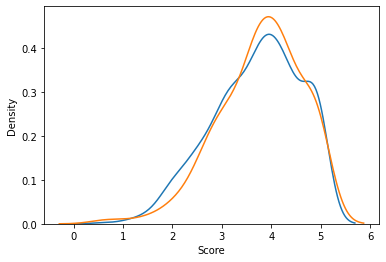

In [37]:
## plot y distribution
import seaborn 
seaborn.kdeplot(train_set['Score'], legend = "train")
seaborn.kdeplot(test_set['Score'], legend = "test")


In [ ]:
!pip install smogn

In [12]:
import smogn

In [192]:
train_reg_smogn = smogn.smoter( data = train_set,y = 'Score', samp_method='extreme', replace=True)
test_reg_smogn = smogn.smoter( data = test_set,y = 'Score', samp_method='extreme', replace=True)

r_index: 100%|##########| 18/18 [00:00<00:00, 135.76it/s]


In [193]:
train_reg_smogn = train_reg_smogn.reset_index(drop=True)
test_reg_smogn = test_reg_smogn.reset_index(drop=True)

train_set.shape, train_reg_smogn.shape

((832, 20), (1399, 20))

<Axes: xlabel='Score', ylabel='Density'>

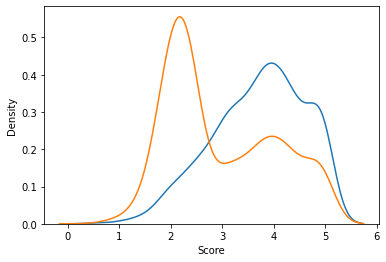

In [140]:
seaborn.kdeplot(train_set['Score'], legend = "Original")
seaborn.kdeplot(train_reg_smogn['Score'], legend = "Modified")

<Axes: xlabel='Score', ylabel='Density'>

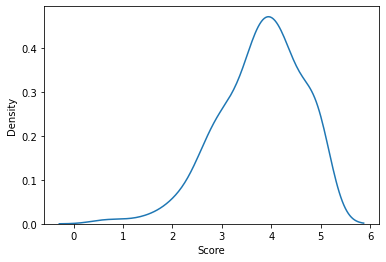

In [141]:
seaborn.kdeplot(test_set['Score'], legend = "Original")
# seaborn.kdeplot(test_reg_smogn['Score'], legend = "Modified")

In [194]:
# smoter for train & test set:
X_train = train_reg_smogn.drop(columns=['Score', 'Result'], axis =1)
y_train= train_reg_smogn.Score
X_test = test_reg_smogn.drop(columns=['Score', 'Result'], axis =1)
y_test= test_reg_smogn.Score


In [142]:
# # smoter for train set only:
X_train = train_reg_smogn.drop(columns=['Score', 'Result'], axis =1)
y_train= train_reg_smogn.Score
X_test = test_set.drop(columns=['Score', 'Result'], axis =1)
y_test= test_set.Score

# LGBMRegressor:


In [16]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor()

In [62]:
lgbm_scaled = TransformedTargetRegressor(regressor=LGBMRegressor(), transformer=MinMaxScaler())
lgbm_scaled_model = lgbm_scaled.fit(X_train, y_train)

smoter for train set only:

In [63]:
# with scaling
y_pred = lgbm_scaled_model.predict(X_test)
lgbm_scaled_model.score(X_train, y_train), lgbm_scaled_model.score(X_test, y_test)

(0.9635947111852419, 0.7393700744070013)

In [64]:
# no Scaling
lgbm_model = lgbm.fit(X_train, y_train)
y_pred2 = lgbm_model.predict(X_test)
lgbm_model.score(X_train, y_train), lgbm_model.score(X_test, y_test)

(0.9635947118269553, 0.7393700714784125)

In [65]:
RMSE_1 = (mean_squared_error(y_test, y_pred))**(1/2)
RMSE_2 = (mean_squared_error(y_test, y_pred2))**(1/2)
RMSE_1, RMSE_2 

(0.43050874075763407, 0.4305087431763568)

In [72]:
predicted = lgbm_model.predict([X_test.loc[0]]) 
real = y_test[0]
predicted[0], real

(4.118100315121855, 3.7331372552352935)

In [121]:
predicted = lgbm_model.predict([X_test.loc[33]]) 
real = y_test[33]
predicted[0], real

(2.138128295719558, 1.9566666670000004)

In [68]:
predicted = lgbm_model.predict([X_test.loc[30]]) 
real = y_test[30]
predicted[0], real

(3.7266126873480094, 4.092527472384616)

In [69]:
predicted = lgbm_model.predict([X_test.loc[49]]) 
real = y_test[49]
predicted[0], real

(4.263698559771855, 4.716333333111111)

In [70]:
predicted = lgbm_model.predict([X_test.loc[50]]) 
real = y_test[50]
predicted[0], real

(2.3637381411472806, 2.303333333)

In [ ]:
feature_importances_lgbm = pd.DataFrame(lgbm_model.feature_importances_, index = X_train.columns, columns = ['importance']).sort_values('importance', ascending=False)


In [75]:
feature_importances_lgbm['feature'] = feature_importances_lgbm.index
feature_importances_lgbm

,importance,feature
avg_recent_references,268,avg_recent_references
paper_len,234,paper_len
avg_words_per_sentence,231,avg_words_per_sentence
ar_word_count,216,ar_word_count
meadian_reference,204,meadian_reference
num_sentences,201,num_sentences
en_word_count,200,en_word_count
ar_word_avg,197,ar_word_avg
oldest_reference,180,oldest_reference
ref_mention_count,178,ref_mention_count


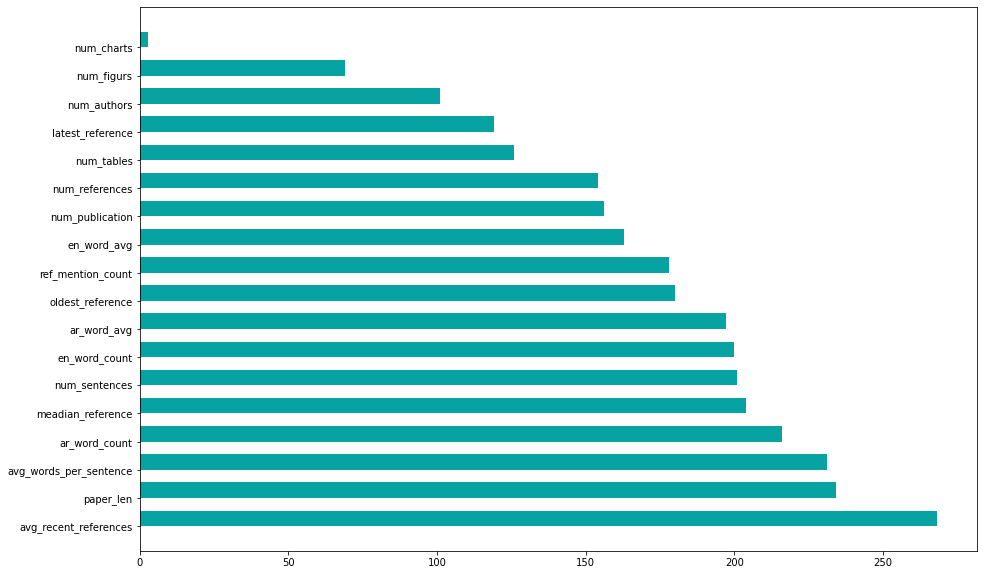

In [76]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.barh(feature_importances_lgbm.feature, feature_importances_lgbm.importance, height=0.55, align="edge", color="#07a2a2");
plt.show()

smoter for train & test set

In [ ]:
# with scaling
y_pred = lgbm_scaled_model.predict(X_test)
lgbm_scaled_model.score(X_train, y_train), lgbm_scaled_model.score(X_test, y_test)

(0.9554707076935761, 0.7646003413446891)

In [ ]:
# no Scaling
lgbm_model = lgbm.fit(X_train, y_train)
y_pred2 = lgbm_model.predict(X_test)
lgbm_model.score(X_train, y_train), lgbm_model.score(X_test, y_test)

(0.9554707082425147, 0.7646003392012015)

In [ ]:
RMSE_1 = (mean_squared_error(y_test, y_pred))**(1/2)
RMSE_2 = (mean_squared_error(y_test, y_pred2))**(1/2)
RMSE_1, RMSE_2 

(0.48443945546079864, 0.48443945869880184)

In [ ]:
predicted = lgbm_model.predict([X_test.loc[0]]) 
real = y_test[0]
predicted[0], real

(3.893969387389412, 3.7331372552352935)

In [ ]:
predicted = lgbm_model.predict([X_test.loc[3]]) 
real = y_test[3]
predicted[0], real

(3.635312866382812, 4.029999999999999)

In [ ]:
predicted = lgbm_model.predict([X_test.loc[30]]) 
real = y_test[30]
predicted[0], real

(3.79320689674686, 3.7258085106382977)

In [ ]:
predicted = lgbm_model.predict([X_test.loc[49]]) 
real = y_test[49]
predicted[0], real

(2.651539950216789, 2.8716666666666666)

In [ ]:
predicted = lgbm_model.predict([X_test.loc[50]]) 
real = y_test[50]
predicted[0], real

(3.602211312939166, 3.108587570288136)

In [ ]:
feature_importances_lgbm = pd.DataFrame(lgbm_model.feature_importances_, index = X_train.columns, columns = ['importance']).sort_values('importance', ascending=False)
feature_importances_lgbm

In [ ]:
feature_importances_lgbm['feature'] = feature_importances_lgbm.index
feature_importances_lgbm

,importance,feature
avg_recent_references,274,avg_recent_references
avg_words_per_sentence,236,avg_words_per_sentence
ar_word_count,222,ar_word_count
en_word_count,221,en_word_count
ref_mention_count,212,ref_mention_count
ar_word_avg,203,ar_word_avg
paper_len,197,paper_len
meadian_reference,192,meadian_reference
oldest_reference,185,oldest_reference
num_sentences,181,num_sentences


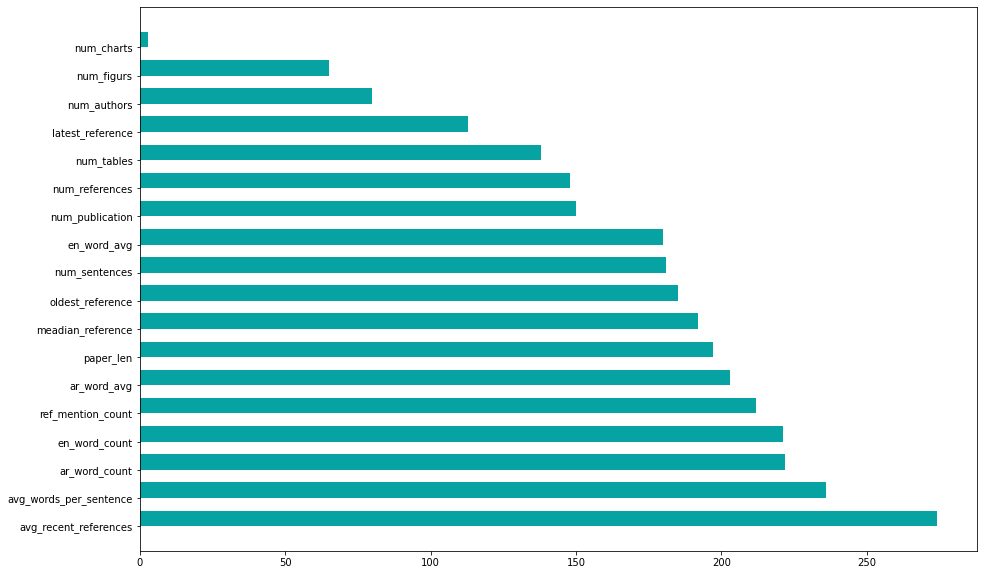

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.barh(feature_importances_lgbm.feature, feature_importances_lgbm.importance, height=0.55, align="edge", color="#07a2a2");
plt.show()

# XGBRegressor:

smoter for train set only:

In [77]:
parameters = {
    'max_depth': [3, 5, 10],
    'n_estimators': [100, 150, 200, 500, 700],
    'learning_rate': [0.05, 0.1, 0.25, 1]
    }
xgbm = XGBRegressor()
xgbm_cv = RandomizedSearchCV(xgbm, parameters, scoring = 'r2')
xgbm_cv.fit(X_train, y_train)
xgbm_cv.score(X_train, y_train), xgbm_cv.score(X_test, y_test)

(0.9995841344698821, 0.8137039839022491)

In [78]:
xgbm_cv.best_params_ 

{'n_estimators': 700, 'max_depth': 5, 'learning_rate': 0.1}

In [79]:
xgbm_cv = XGBRegressor(n_estimators= 700, learning_rate=0.1, max_depth=10)
# with scaling:
regression_xgbm_cv = TransformedTargetRegressor(regressor=xgbm_cv, transformer=MinMaxScaler())

regression_xgbm_cv.fit(X_train, y_train)
y_pred = regression_xgbm_cv.predict(X_test)
regression_xgbm_cv.score(X_test, y_test), regression_xgbm_cv.score(X_train, y_train)

(0.826783628899986, 0.9999713731433432)

In [94]:
# no scaling:
xgbm_cv.fit(X_train, y_train)
y_pred2 = xgbm_cv.predict(X_test)
xgbm_cv.score(X_test, y_test), xgbm_cv.score(X_train, y_train)

(0.8058538216699973, 0.9999979015071316)

In [95]:
RMSE_cv_1 = (mean_squared_error(y_test, y_pred))**(1/2)
RMSE_cv_2 = (mean_squared_error(y_test, y_pred2))**(1/2)
RMSE_cv_1, RMSE_cv_2 

(0.35096539825694384, 0.37156453642135234)

In [96]:
predicted = xgbm_cv.predict(X_test[0:1]) 
real = y_test[0]
predicted[0], real

(4.1826754, 3.7331372552352935)

In [122]:
predicted = xgbm_cv.predict(X_test.loc[33:34]) 
real = y_test[33]
predicted[0], real

(1.956656, 1.9566666670000004)

In [98]:
predicted = xgbm_cv.predict(X_test.loc[30:31]) 
real = y_test[30]
predicted[0], real

(4.091426, 4.092527472384616)

In [99]:
predicted = xgbm_cv.predict(X_test.loc[49:50]) 
real = y_test[49]
predicted[0], real

(4.7148504, 4.716333333111111)

In [100]:
predicted = xgbm_cv.predict(X_test.loc[50:51]) 
real = y_test[50]
predicted[0], real

(2.3041782, 2.303333333)

In [ ]:
# xgbm_cv.feature_importances_
feature_importances_xgbm = pd.DataFrame(xgbm_cv.feature_importances_, index = X_train.columns, columns = ['importance']).sort_values('importance', ascending=False)
feature_importances_xgbm

In [91]:
feature_importances_xgbm['feature'] = feature_importances_xgbm.index
feature_importances_xgbm

,importance,feature
num_authors,0.237559,num_authors
avg_recent_references,0.119514,avg_recent_references
num_publication,0.097708,num_publication
en_word_count,0.092330,en_word_count
num_references,0.085529,num_references
ref_mention_count,0.063897,ref_mention_count
num_sentences,0.055902,num_sentences
avg_words_per_sentence,0.045798,avg_words_per_sentence
ar_word_count,0.031227,ar_word_count
paper_len,0.029837,paper_len


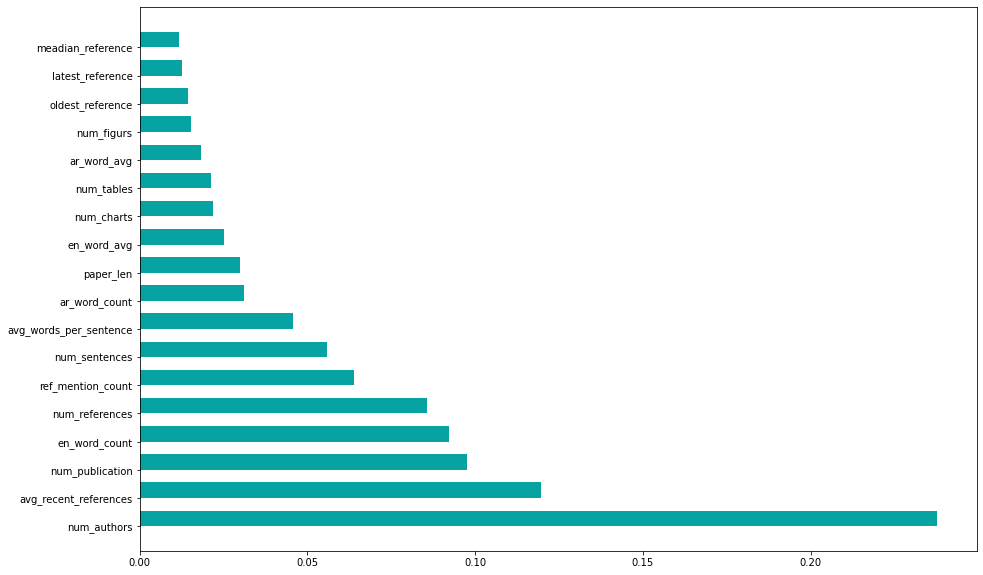

In [92]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.barh(feature_importances_xgbm.feature, feature_importances_xgbm.importance, height=0.55, align="edge", color="#07a2a2");
plt.show()

In [102]:
xgbm_cv.save_model("/content/drive/MyDrive/Colab Notebooks/trained_ML_models/xgbm_regressor_palanced2.json")

In [103]:
xgbm2 = XGBRegressor()
xgbm2.load_model('/content/drive/MyDrive/Colab Notebooks/trained_ML_models/xgbm_regressor_palanced2.json')

In [104]:
xgbm2.score(X_test, y_test), xgbm2.score(X_train, y_train)

(0.8058538216699973, 0.9999979015071316)

smoter for train & test set:

In [ ]:
parameters = {
    'max_depth': [3, 5, 10],
    'n_estimators': [100, 150, 200, 500, 700],
    'learning_rate': [0.05, 0.1, 0.25, 1]
    }
xgbm = XGBRegressor()
xgbm_cv = RandomizedSearchCV(xgbm, parameters, scoring = 'r2')
xgbm_cv.fit(X_train, y_train)
xgbm_cv.score(X_train, y_train), xgbm_cv.score(X_test, y_test)

(0.9844505972275454, 0.8133335314366905)

In [ ]:
xgbm_cv.best_params_ 

{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05}

In [ ]:
xgbm_cv = XGBRegressor(n_estimators= 200, learning_rate=0.1, max_depth=10)
# with scaling:
regression_xgbm_cv = TransformedTargetRegressor(regressor=xgbm_cv, transformer=MinMaxScaler())

regression_xgbm_cv.fit(X_train, y_train)
y_pred = regression_xgbm_cv.predict(X_test)
regression_xgbm_cv.score(X_test, y_test), regression_xgbm_cv.score(X_train, y_train)

(0.8207405703313758, 0.9999661171083648)

In [ ]:
# no scaling:
xgbm_cv.fit(X_train, y_train)
y_pred2 = xgbm_cv.predict(X_test)
xgbm_cv.score(X_test, y_test), xgbm_cv.score(X_train, y_train)


(0.8345038682053164, 0.999977022199625)

In [ ]:
RMSE_cv_1 = (mean_squared_error(y_test, y_pred))**(1/2)
RMSE_cv_2 = (mean_squared_error(y_test, y_pred2))**(1/2)
RMSE_cv_1, RMSE_cv_2 

(0.4864127523068868, 0.46736681326478036)

In [ ]:
predicted = xgbm_cv.predict(X_test[0:1]) 
real = y_test[0]
predicted[0], real

(3.737715, 3.7331372552352935)

In [ ]:
predicted = xgbm_cv.predict(X_test.loc[3:4]) 
real = y_test[3]
predicted[0], real

(4.0250964, 4.029999999999999)

In [ ]:
predicted = xgbm_cv.predict(X_test.loc[30:31]) 
real = y_test[30]
predicted[0], real

(3.726325, 3.7258085106382977)

In [ ]:
predicted = xgbm_cv.predict(X_test.loc[49:50]) 
real = y_test[49]
predicted[0], real

(2.8648913, 2.8716666666666666)

In [ ]:
predicted = xgbm_cv.predict(X_test.loc[50:51]) 
real = y_test[50]
predicted[0], real

(2.9396415, 3.108587570288136)

In [ ]:
# xgbm_cv.feature_importances_
feature_importances_xgbm = pd.DataFrame(xgbm_cv.feature_importances_, index = X_train.columns, columns = ['importance']).sort_values('importance', ascending=False)
feature_importances_xgbm

In [ ]:
feature_importances_xgbm['feature'] = feature_importances_xgbm.index
feature_importances_xgbm

,importance,feature
num_authors,0.284293,num_authors
en_word_count,0.113194,en_word_count
num_references,0.103218,num_references
avg_recent_references,0.093516,avg_recent_references
num_publication,0.092710,num_publication
ref_mention_count,0.046851,ref_mention_count
avg_words_per_sentence,0.045675,avg_words_per_sentence
ar_word_count,0.037009,ar_word_count
num_tables,0.029902,num_tables
num_sentences,0.029579,num_sentences


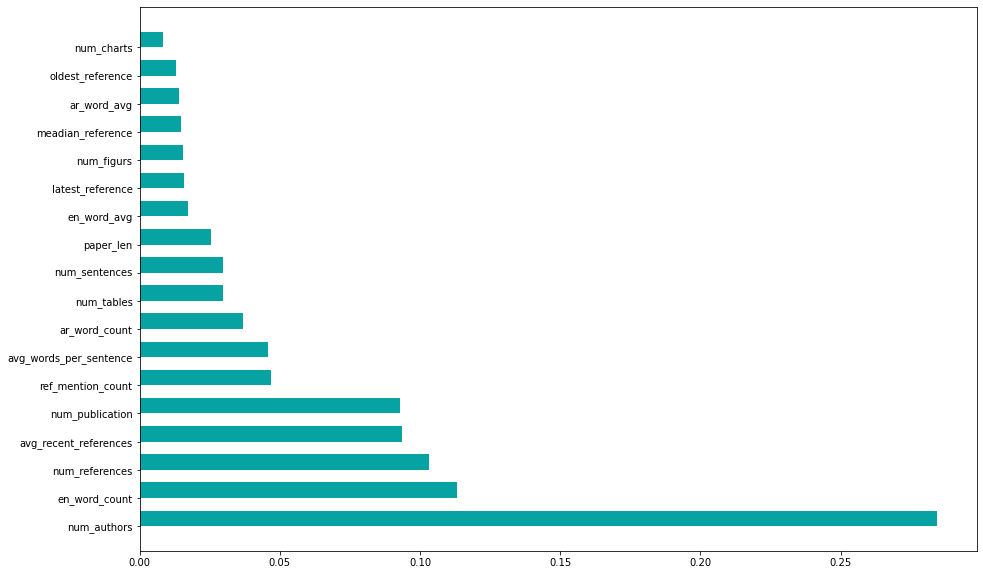

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.barh(feature_importances_xgbm.feature, feature_importances_xgbm.importance, height=0.55, align="edge", color="#07a2a2");
plt.show()

In [ ]:
xgbm_cv.save_model("/content/drive/MyDrive/Colab Notebooks/trained_ML_models/xgbm_regressor_palanced.json")

In [ ]:
xgbm2 = XGBRegressor()
xgbm2.load_model('/content/drive/MyDrive/Colab Notebooks/trained_ML_models/xgbm_regressor_palanced.json')

In [ ]:
xgbm2.score(X_test, y_test), xgbm2.score(X_train, y_train)

(0.833247358631348, 0.9170008796247775)

# Random forest:

smoter for train set only:

In [143]:
parameters = {
    'n_estimators': [50,100,200],
    'max_depth': [5, 10, 50],
    'max_features': [15, 50, 100],
    }
rf = RandomForestRegressor()
rf_c = RandomizedSearchCV(rf, parameters, scoring = 'r2')
rf_c.fit(X_train, y_train)
rf_c.best_params_

{'n_estimators': 100, 'max_features': 50, 'max_depth': 50}

In [148]:
# with scaling:
rf_cv = RandomForestRegressor(n_estimators = 100, max_features= 50, max_depth = 50)
regression_rf_cv = TransformedTargetRegressor(regressor=rf_cv, transformer=MinMaxScaler())

regression_rf_cv.fit(X_train, y_train)
y_pred = regression_rf_cv.predict(X_test)
regression_rf_cv.score(X_test, y_test), regression_rf_cv.score(X_train, y_train)

(0.7334303248680213, 0.9551504094591476)

In [149]:
# no scaling:
rf_cv.fit(X_train,y_train)
y_pred = rf_cv.predict(X_test)
rf_cv.score(X_test, y_test), rf_cv.score(X_train, y_train)

(0.7352846788839325, 0.9538868486263213)

In [150]:
RMSE_cv = (mean_squared_error(y_test, y_pred))**(1/2)
RMSE_cv

0.4338697509061191

In [151]:
result = rf_cv.predict([X_test.loc[0]])
result[0], y_test[0]

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


(3.8194335414174105, 3.7331372552352935)

In [152]:
result = rf_cv.predict([X_test.loc[33]])
result[0], y_test[33]

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


(2.099356685243145, 1.9566666670000004)

In [153]:
result = rf_cv.predict([X_test.loc[30]])
result[0], y_test[30]

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


(3.6419842126396422, 4.092527472384616)

In [154]:
result = rf_cv.predict([X_test.loc[49]])
result[0], y_test[49]

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


(4.384309695948549, 4.716333333111111)

In [155]:
result = rf_cv.predict([X_test.loc[50]])
result[0], y_test[50]

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


(2.4769122639857186, 2.303333333)

In [ ]:
feature_importances_rf= pd.DataFrame(rf_cv.feature_importances_, index = X_train.columns, columns = ['importance']).sort_values('importance', ascending=False)
feature_importances_rf

In [186]:
feature_importances_rf['feature'] = feature_importances_rf.index
feature_importances_rf

,importance,feature
num_references,0.228096,num_references
avg_recent_references,0.139210,avg_recent_references
en_word_count,0.116184,en_word_count
num_authors,0.079175,num_authors
ref_mention_count,0.065121,ref_mention_count
num_publication,0.060835,num_publication
avg_words_per_sentence,0.043780,avg_words_per_sentence
paper_len,0.035062,paper_len
meadian_reference,0.029733,meadian_reference
num_sentences,0.028820,num_sentences


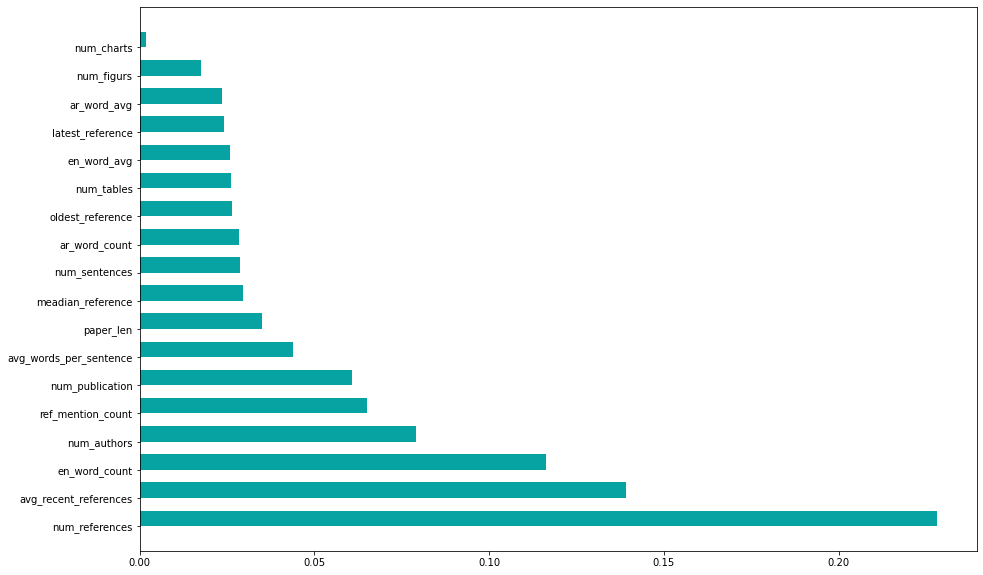

In [187]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.barh(feature_importances_rf.feature, feature_importances_rf.importance, height=0.55, align="edge", color="#07a2a2");
plt.show()

smoter for train &test set:

In [ ]:
parameters = {
    'n_estimators': [50,100,200],
    'max_depth': [5, 10, 50],
    'max_features': [15, 50, 100],
    }
rf = RandomForestRegressor()
rf_c = RandomizedSearchCV(rf, parameters, scoring = 'r2')
rf_c.fit(X_train, y_train)
rf_c.best_params_

{'n_estimators': 100, 'max_features': 50, 'max_depth': 50}

In [ ]:
# with scaling:
rf_cv = RandomForestRegressor(n_estimators = 200, max_features= 100, max_depth = 50)
regression_rf_cv = TransformedTargetRegressor(regressor=rf_cv, transformer=MinMaxScaler())

regression_rf_cv.fit(X_train, y_train)
y_pred = regression_rf_cv.predict(X_test)
regression_rf_cv.score(X_test, y_test), regression_rf_cv.score(X_train, y_train)

(0.8142390418678124, 0.9527875594737291)

In [ ]:
# no scaling:
rf_cv.fit(X_train,y_train)
y_pred = rf_cv.predict(X_test)
rf_cv.score(X_test, y_test), rf_cv.score(X_train, y_train)

(0.8057336783215705, 0.9511329593595547)

In [ ]:
RMSE_cv = (mean_squared_error(y_test, y_pred))**(1/2)
RMSE_cv

0.4951549994700291

In [ ]:
import joblib
joblib.dump(regression_rf_cv,"/content/drive/MyDrive/Colab Notebooks/trained_ML_models/rf_regressor_palanced.pkl")

['/content/drive/MyDrive/Colab Notebooks/trained_ML_models/rf_regressor_palanced.pkl']

In [ ]:
loaded_rf = joblib.load("/content/drive/MyDrive/Colab Notebooks/trained_ML_models/rf_regressor_palanced.pkl")

In [ ]:
loaded_rf.score(X_test, y_test), loaded_rf.score(X_train, y_train)

(0.8142390418678124, 0.9527875594737291)

In [ ]:
result = regression_rf_cv.predict([X_test.loc[0]])
result, y_test[0]

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


(array([3.77083647]), 3.7331372552352935)

In [ ]:
result = regression_rf_cv.predict([X_test.loc[3]])
result, y_test[3]

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


(array([3.56359777]), 4.029999999999999)

In [ ]:
result = regression_rf_cv.predict([X_test.loc[30]])
result, y_test[30]

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


(array([3.77171625]), 3.7258085106382977)

In [ ]:
result = regression_rf_cv.predict([X_test.loc[49]])
result, y_test[49]

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


(array([2.66574085]), 2.8716666666666666)

In [ ]:
result = regression_rf_cv.predict([X_test.loc[50]])
result, y_test[50]

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


(array([3.30099256]), 3.108587570288136)

In [ ]:
result = regression_rf_cv.predict([X_test.loc[136]])
result, y_test[136]

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


(array([4.12373096]), 4.741666667)

In [ ]:
feature_importances_rf= pd.DataFrame(lgbm_model.feature_importances_, index = X_train.columns, columns = ['importance']).sort_values('importance', ascending=False)
feature_importances_rf

In [ ]:
feature_importances_rf['feature'] = feature_importances_rf.index
feature_importances_rf

,importance,feature
avg_recent_references,274,avg_recent_references
avg_words_per_sentence,236,avg_words_per_sentence
ar_word_count,222,ar_word_count
en_word_count,221,en_word_count
ref_mention_count,212,ref_mention_count
ar_word_avg,203,ar_word_avg
paper_len,197,paper_len
meadian_reference,192,meadian_reference
oldest_reference,185,oldest_reference
num_sentences,181,num_sentences


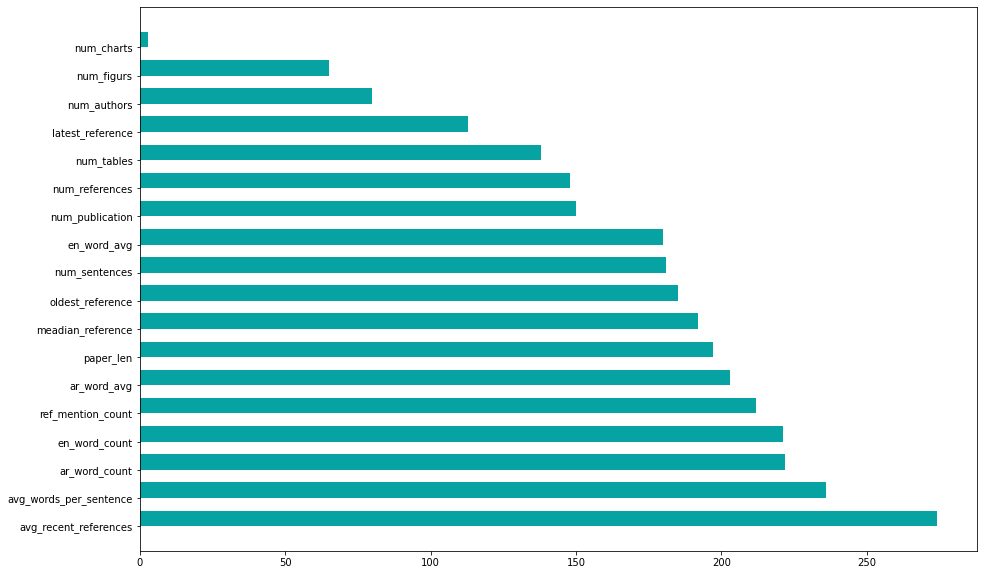

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.barh(feature_importances_rf.feature, feature_importances_rf.importance, height=0.55, align="edge", color="#07a2a2");
plt.show()

# DecisionTreeRegressor

smoter for train set only:

In [164]:
dt_cv = DecisionTreeRegressor()
# with scaling:

regression_df = TransformedTargetRegressor(regressor=dt_cv, transformer=MinMaxScaler())

regression_df_cv = regression_df.fit(X_train,y_train)
y_pred = regression_df_cv.predict(X_test)
regression_df_cv.score(X_test, y_test), regression_df_cv.score(X_train, y_train)

(0.639468125773248, 1.0)

In [182]:
# no scaling:
dt = DecisionTreeRegressor()
dt_cv = dt.fit(X_train,y_train)
y_pred = dt_cv.predict(X_test)
dt_cv.score(X_test, y_test), dt_cv.score(X_train, y_train)

(0.6771767972117392, 1.0)

In [183]:
RMSE_cv = (mean_squared_error(y_test, y_pred))**(1/2)
RMSE_cv

0.47912872028501446

In [184]:
result = dt_cv.predict([X_test.loc[0]])
result[0], y_test[0]

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


(3.7331372552352935, 3.7331372552352935)

In [170]:
result = dt_cv.predict([X_test.loc[33]])
result[0], y_test[33]

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


(1.9566666670000004, 1.9566666670000004)

In [171]:
result = dt_cv.predict([X_test.loc[30]])
result[0], y_test[30]

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


(4.092527472384616, 4.092527472384616)

In [172]:
result = dt_cv.predict([X_test.loc[49]])
result[0], y_test[49]

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


(4.716333333111111, 4.716333333111111)

In [175]:
result = dt_cv.predict([X_test.loc[50]])
result[0], y_test[50]

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


(2.303333333, 2.303333333)

In [ ]:
feature_importances_rf= pd.DataFrame(dt_cv.feature_importances_, index = X_train.columns, columns = ['importance']).sort_values('importance', ascending=False)
feature_importances_rf

In [178]:
feature_importances_rf['feature'] = feature_importances_rf.index
feature_importances_rf

,importance,feature
num_references,0.248129,num_references
avg_recent_references,0.138489,avg_recent_references
num_authors,0.105112,num_authors
en_word_count,0.096897,en_word_count
avg_words_per_sentence,0.063849,avg_words_per_sentence
num_publication,0.053889,num_publication
ref_mention_count,0.047691,ref_mention_count
num_sentences,0.036545,num_sentences
paper_len,0.034608,paper_len
meadian_reference,0.030714,meadian_reference


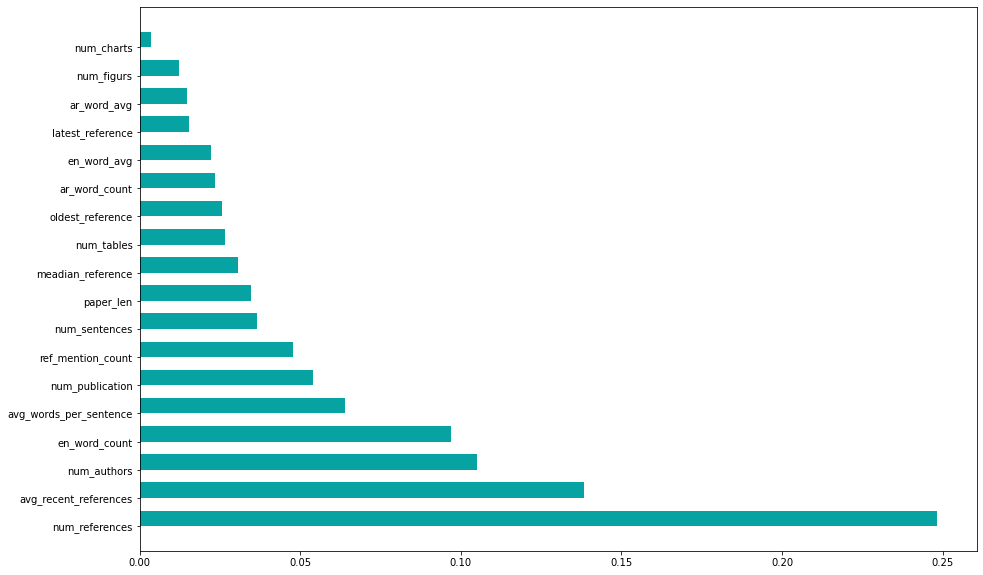

In [179]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.barh(feature_importances_rf.feature, feature_importances_rf.importance, height=0.55, align="edge", color="#07a2a2");
plt.show()

smoter for train & test set:

In [198]:
dt_cv = DecisionTreeRegressor()
regression_df = TransformedTargetRegressor(regressor=dt_cv, transformer=MinMaxScaler())

regression_df_cv= regression_df.fit(X_train,y_train)
y_pred = regression_df_cv.predict(X_test)
regression_df_cv.score(X_test, y_test), regression_df_cv.score(X_train, y_train)

(0.6386255674144226, 1.0)

In [205]:
# no scaling:
dt = DecisionTreeRegressor()
dt_cv = dt.fit(X_train,y_train)
y_pred = dt_cv.predict(X_test)
dt_cv.score(X_test, y_test), dt_cv.score(X_train, y_train)

(0.6302900838883012, 1.0)

In [207]:
RMSE_cv = (mean_squared_error(y_test, y_pred))**(1/2)
RMSE_cv

0.6648815251419057

In [208]:
result = dt_cv.predict([X_test.loc[0]])
result[0], y_test[0]

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


(3.7331372552352935, 3.7331372552352935)

In [209]:
result = dt_cv.predict([X_test.loc[33]])
result[0], y_test[33]

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


(3.549999999666668, 3.549999999666668)

In [210]:
result = dt_cv.predict([X_test.loc[30]])
result[0], y_test[30]

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


(1.9566666670000004, 1.9566666670000004)

In [211]:
result = dt_cv.predict([X_test.loc[49]])
result[0], y_test[49]

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


(3.4351190472857143, 3.108587570288136)

In [212]:
result = dt_cv.predict([X_test.loc[50]])
result[0], y_test[50]

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


(3.296823899037736, 4.968944444555555)

In [ ]:
feature_importances_rf= pd.DataFrame(dt_cv.feature_importances_, index = X_train.columns, columns = ['importance']).sort_values('importance', ascending=False)
feature_importances_rf

In [214]:
feature_importances_rf['feature'] = feature_importances_rf.index
feature_importances_rf

,importance,feature
num_references,0.244992,num_references
avg_recent_references,0.137736,avg_recent_references
num_authors,0.104854,num_authors
en_word_count,0.096292,en_word_count
avg_words_per_sentence,0.059933,avg_words_per_sentence
num_publication,0.051989,num_publication
ref_mention_count,0.049400,ref_mention_count
paper_len,0.038401,paper_len
num_sentences,0.035581,num_sentences
meadian_reference,0.035336,meadian_reference


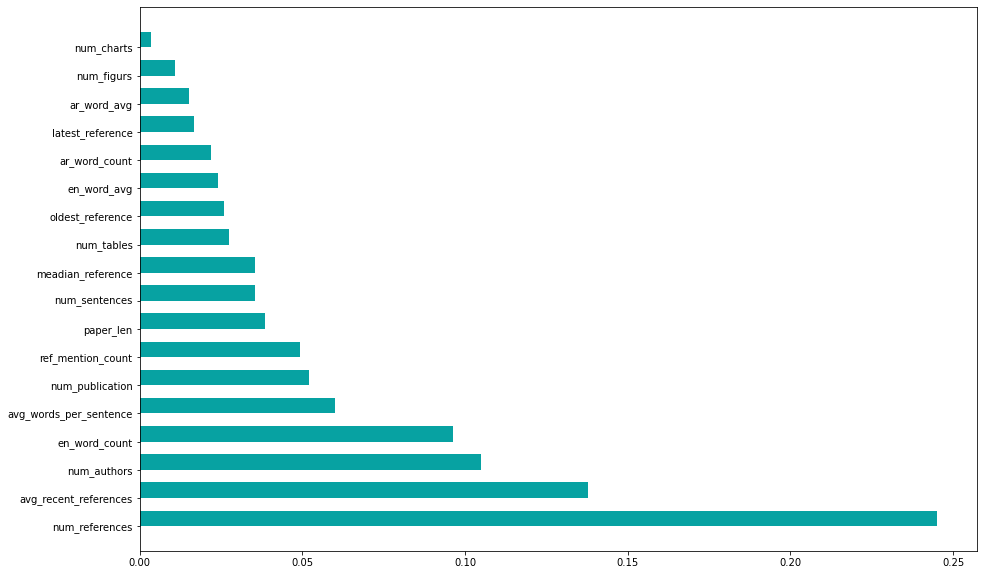

In [215]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.barh(feature_importances_rf.feature, feature_importances_rf.importance, height=0.55, align="edge", color="#07a2a2");
plt.show()